In [165]:
# import necessary libraries 
import pyarrow
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from tensorflow import keras
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score)
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers, models
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, roc_curve
import pickle



In [166]:
tf.keras.utils.set_random_seed(42)

# Paths

In [167]:
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')
minority_users_nn_pq = os.path.join(processed_dir, 'minority_users_nn_smote.parquet')

models_dir = os.path.join( "..", "models","models")
model_dump_path = os.path.join(models_dir, 'nn_model_smote.pkl')

Import Dataset

In [169]:
# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds['malicious'] = fds['malicious'].astype(int)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,0
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,0
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,0
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,0
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,0
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,0
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,0
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,0


In [170]:
X = fds.drop(columns = ['malicious']).compute()
y = fds['malicious'].compute()

In [171]:
# Split the fds into training and testing sets
X_train_w_name, X_test_w_name, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train_w_name.drop(columns=["user",]), X_test_w_name.drop(columns=["user",])

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


## SMOTE

In [172]:
#transform the dataset
oversample = SMOTE(sampling_strategy=0.4, random_state=42) #sampling_strategy=0.8
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(y_train))

Train Labels after Resampling
Counter({0: 1574, 1: 629})


**Feature Normalisation**

In [173]:
# Standardize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
print(X_test.shape,X_train.shape)

(400, 17) (2203, 17)


**Hyperparameter Tuning**

In [174]:
# Define the neural network architecture
def create_model(neurons_layer1=64, neurons_layer2=32, learning_rate=0.01):
    model = Sequential([
        Dense(neurons_layer1, activation='relu', input_shape=(17,)),
        Dense(neurons_layer2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define parameter values to loop over
neurons_layer1_values = [32, 64, 128]
neurons_layer2_values = [16, 32, 64]
learning_rates = [0.001, 0.01, 0.1]

best_accuracy = 0
best_params = {}

# Iterate over parameter combinations
for neurons_layer1 in neurons_layer1_values:
    for neurons_layer2 in neurons_layer2_values:
        for learning_rate in learning_rates:
            # Create the model
            model = create_model(neurons_layer1=neurons_layer1, neurons_layer2=neurons_layer2, learning_rate=learning_rate)
            
            # Train the model
            history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, shuffle=True, verbose=0)
            
            # Evaluate the model
            loss, accuracy = model.evaluate(X_test, y_test)
            
            # Check if current accuracy is better than the best accuracy so far
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'neurons_layer1': neurons_layer1, 'neurons_layer2': neurons_layer2, 'learning_rate': learning_rate}

# Print best parameters and corresponding accuracy
print("Best parameters found: ", best_params)
print("Best accuracy: ", best_accuracy)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.9744 - loss: 0.0752
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9893 - loss: 0.1781
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.9883 - loss: 0.1477
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.9703 - loss: 0.0757
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.9934 - loss: 0.1449   
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.9883 - loss: 0.1477
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.9708 - loss: 0.0805
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.9915 - loss: 0.3014   
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - accuracy: 0.9607 - loss: 0.1672
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.9849 - loss: 0.0602
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - accuracy: 0.9915 - loss: 0.1837
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.9817 - loss: 0.1316
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9784 - loss: 0.0612
13/13 ━━━━━━━━━━━━━

**Evaluating Model**

In [175]:
# Define the neural network architecture
model = Sequential([
    Dense(32, activation='relu', input_shape=(17,)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate = 0.01)
# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['recall'])


In [176]:
history = model.fit(X_train, y_train,
                    epochs = 50,
                    batch_size = 64,
                    validation_split = 0.2,
                    shuffle = True,
                    #callbacks = [early_stopping]
                    )

# Evaluate the model
loss, accuracy = model.evaluate(X_train, y_train)
print("Final Loss:", loss)
print("Final Accuracy:", accuracy)

Epoch 1/50


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4706 - recall: 0.0000e+00 - val_loss: 2.0124 - val_recall: 0.0000e+00
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3303 - recall: 0.0000e+00 - val_loss: 2.0180 - val_recall: 0.0000e+00
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3045 - recall: 0.0000e+00 - val_loss: 1.7531 - val_recall: 0.0000e+00
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.2858 - recall: 0.0000e+00 - val_loss: 1.6972 - val_recall: 0.0000e+00
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.2648 - recall: 0.0000e+00 - val_loss: 1.4521 - val_recall: 0.0000e+00
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.2309 - recall: 0.0000e+00 - val_loss: 1.4518 - val_recall: 0.0000e+00
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.1881 - recall: 0.0299 - val_loss: 1.0650 - val_recall: 0.1224
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 0.1462 - recall: 0.3366 - val_loss: 0.982

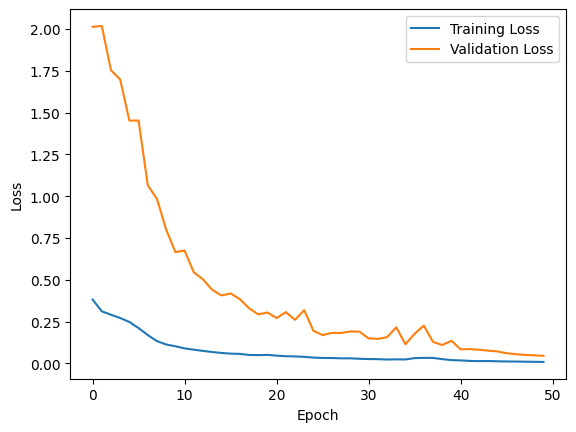

In [177]:
# loss plot
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

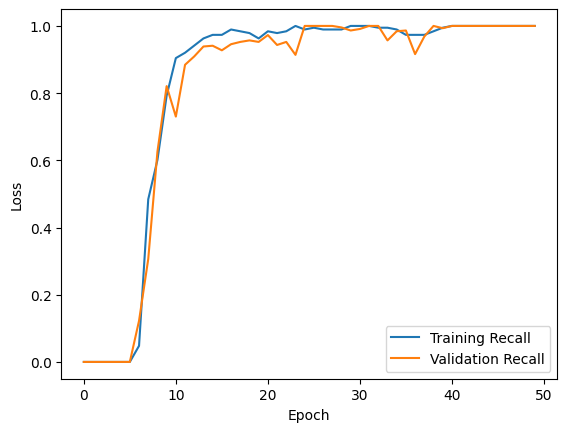

In [178]:
# acc plot
plt.plot(history.history["recall"], label="Training Recall")
plt.plot(history.history["val_recall"], label="Validation Recall")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Prediction

Threshold:  0.1
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
Accuracy = 98.50%
Precision = 0.25
Recall = 0.25
F1 score = 0.25

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       396
           1       0.25      0.25      0.25         4

    accuracy                           0.98       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.98      0.98      0.98       400



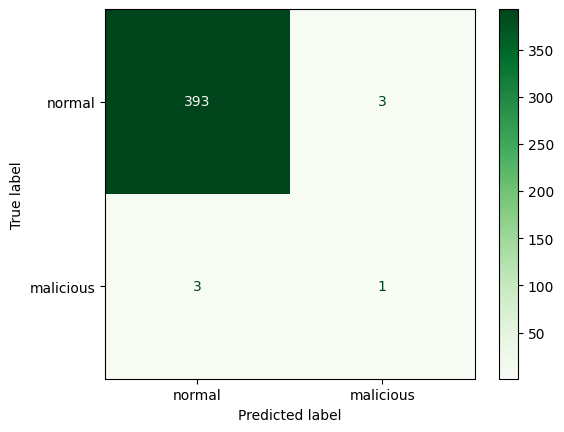

Threshold:  0.2
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy = 98.50%
Precision = 0.25
Recall = 0.25
F1 score = 0.25

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       396
           1       0.25      0.25      0.25         4

    accuracy                           0.98       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.98      0.98      0.98       400



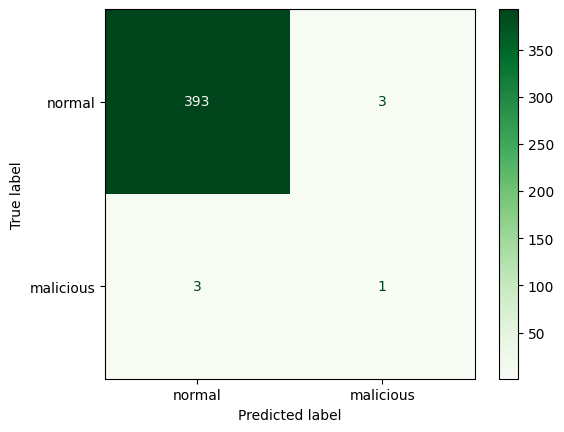

Threshold:  0.3
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
Accuracy = 98.50%
Precision = 0.0
Recall = 0.0
F1 score = 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.98       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.98      0.98       400



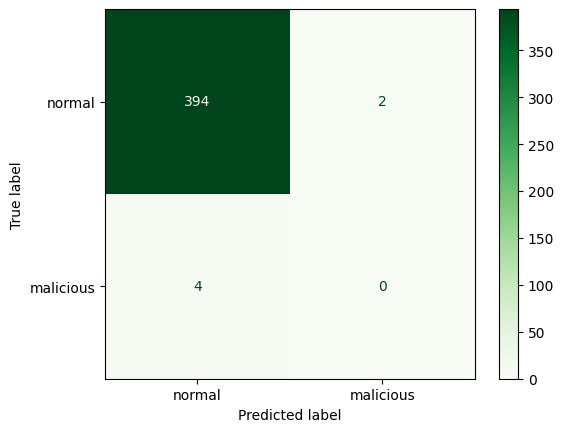

Threshold:  0.4
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
Accuracy = 98.50%
Precision = 0.0
Recall = 0.0
F1 score = 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.98       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.98      0.98       400



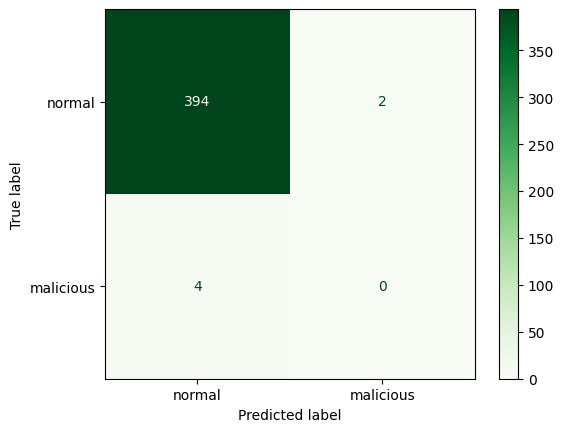

Threshold:  0.5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
Accuracy = 98.75%
Precision = 0.0
Recall = 0.0
F1 score = 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.98       400



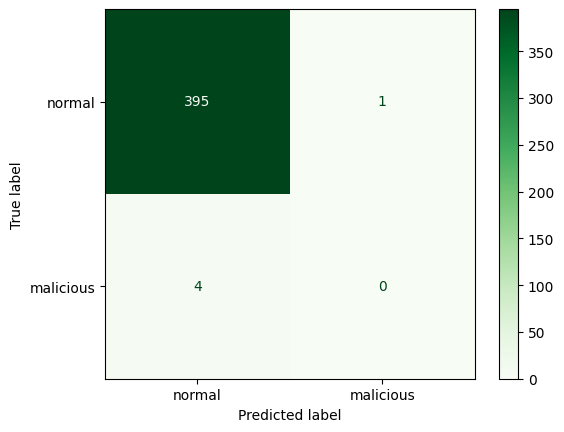

Threshold:  0.6
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
Accuracy = 98.75%
Precision = 0.0
Recall = 0.0
F1 score = 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.98       400



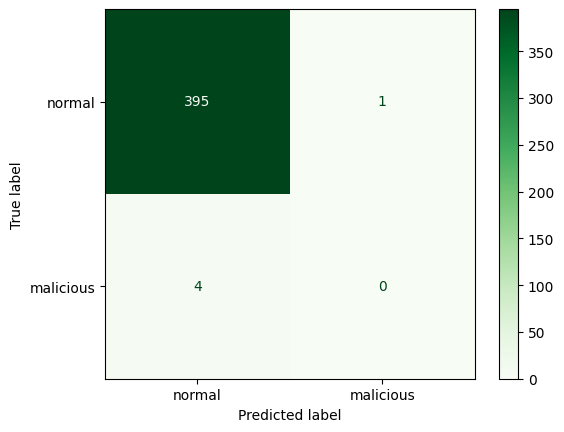

Threshold:  0.7
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
Accuracy = 99.00%
Precision = 0.0
Recall = 0.0
F1 score = 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

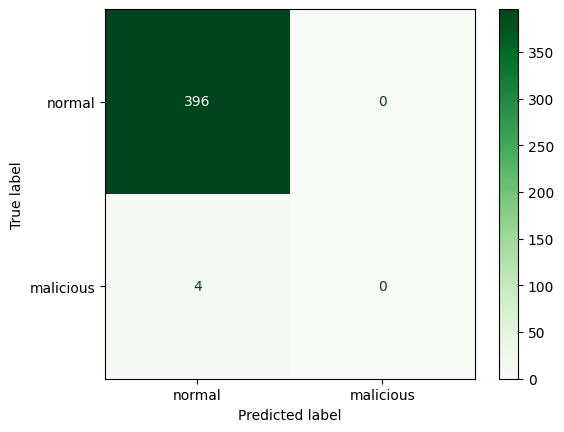

Threshold:  0.8
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Accuracy = 99.00%
Precision = 0.0
Recall = 0.0
F1 score = 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



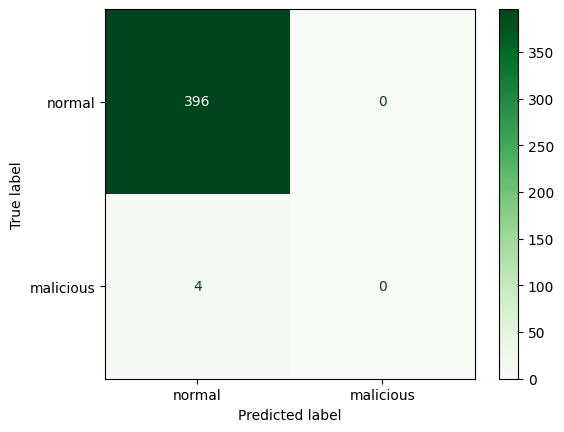

Threshold:  0.9
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
Accuracy = 99.00%
Precision = 0.0
Recall = 0.0
F1 score = 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

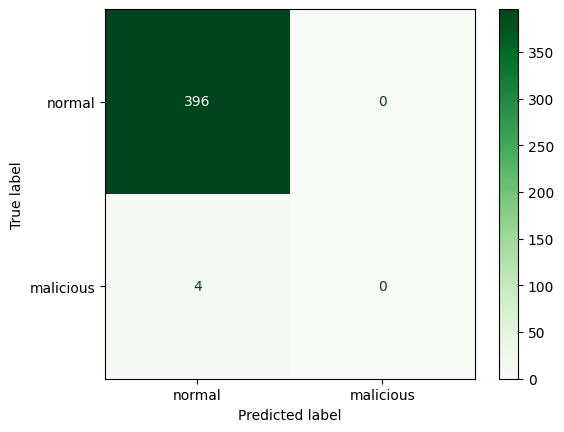

0.1


In [187]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_threshold = 0
max_f1 = 0

for threshold in thresholds:
    print("Threshold: ", threshold)
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > threshold).astype(int)
    set(list(y_pred.flatten()))
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['normal', 'malicious'])

    print("Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
    print("Precision = {}".format(precision_score(y_test, y_pred)))
    print("Recall = {}".format(recall_score(y_test, y_pred)))
    print("F1 score = {}".format(f1_score(y_test, y_pred)))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    disp.plot(cmap=plt.cm.Greens)
    plt.show()
    if f1_score(y_test, y_pred) > max_f1:
        max_f1 = f1_score(y_test, y_pred)
        best_threshold = threshold

print(best_threshold)
threshold = best_threshold

AUC score: 0.5


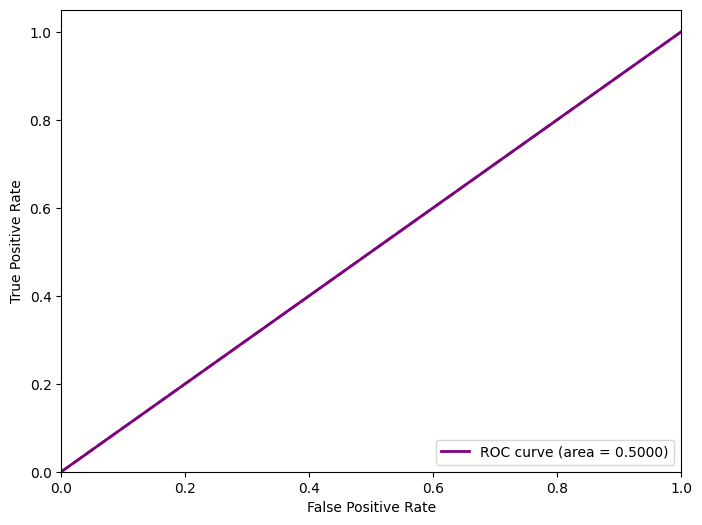

In [188]:
# ROC - AUC
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    plt.figure(figsize=(8, 6))
    dt_fpr, dt_tpr, thresholds = roc_curve(true_y, y_prob)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, color='purple', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.legend(loc="lower right")

    # plt.legend()

plot_roc_curve(y_test, y_pred)
print(f'AUC score: {roc_auc_score(y_test, y_pred)}')

### Risk scores

In [189]:
def get_risk_score(X,threshold):    
    prob = model.predict(X)
    data = abs(threshold- prob)
    scaler = MinMaxScaler()
    confidence = scaler.fit_transform(data)
    return confidence

In [190]:
train_risk = get_risk_score(X_train,threshold)
test_risk = get_risk_score(X_test,threshold)

 1/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


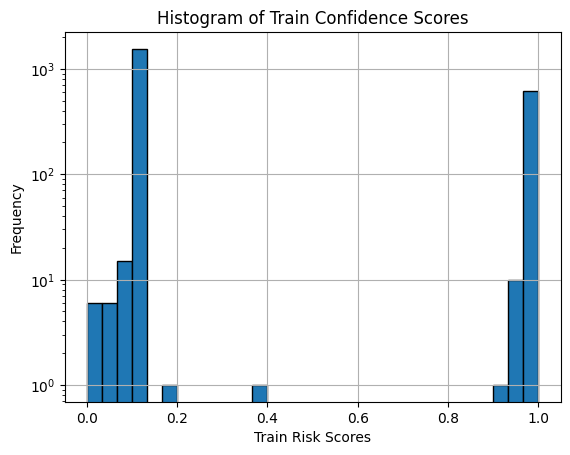

In [191]:
# Plot histogram for train risk score
plt.yscale('log')
plt.hist(train_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Confidence Scores')
plt.grid(True)
plt.show()

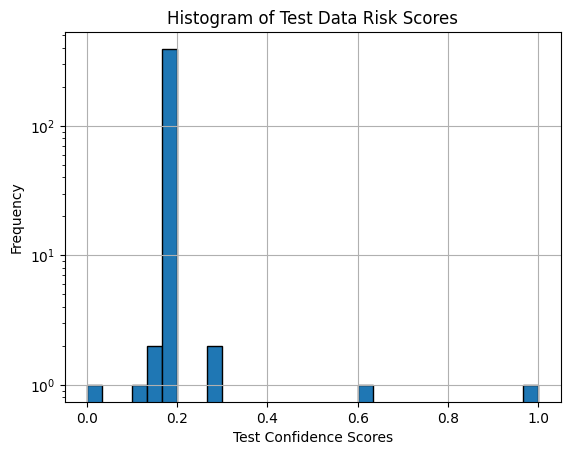

In [192]:
# Plot histogram for test risk score
plt.yscale('log')
plt.hist(test_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Test Confidence Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()


In [193]:
print("Example Train Risk Scores:")
print(train_risk[:10])  
print("\nExample Test Risk Scores:")
print(test_risk[:10])

Example Train Risk Scores:
[[0.10609393]
 [0.10609294]
 [0.10609393]
 [0.10609393]
 [0.10609354]
 [0.10609393]
 [0.10609393]
 [0.10609393]
 [0.10596848]
 [0.10609393]]

Example Test Risk Scores:
[[0.17426056]
 [0.17426056]
 [0.17426056]
 [0.17424394]
 [0.        ]
 [0.17426056]
 [0.17426056]
 [0.17426056]
 [0.17426056]
 [0.17426056]]


# Export Model

In [194]:
pickle.dump(model.weights, open(model_dump_path,'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '../models/models/nn_model_smote.pkl'

#  Our Prediction and the Confidence Associated with it

## Helper Functions

In [ ]:
def df_toparquet(pdf,path):
    ddf = dd.from_pandas(pdf)
    # Export the DataFrame to a parquet file=
    ddf.to_parquet(path, engine='pyarrow')


In [ ]:
def get_minority_tables(y_pred_value, y_test_value,df):
    # Get rows of minority data
    minority_data = df[(df['Actual'] == y_test_value) & (df['Prediction'] == y_pred_value)]
    display(minority_data)

Creating Table for export

In [ ]:
names_array = list(X_test_w_name['user'])
final_guess = {'User': names_array, 'Actual': list(y_test.astype(bool)), 'Prediction': list(y_pred.flatten().astype(bool)), 'Confidence of Prediction': list(test_risk.flatten())}
refactored_df = pd.DataFrame(final_guess)
df_toparquet(refactored_df,minority_users_nn_pq)
refactored_df


,User,Actual,Prediction,Confidence of Prediction
0,VAH1292,False,False,1.000000
1,CJL0143,False,False,1.000000
2,MMB1967,False,False,1.000000
3,IVS1411,False,False,0.999571
4,MEB1743,False,False,0.950680
...,...,...,...,...
395,JIG1593,False,False,1.000000
396,MDL0294,False,False,1.000000
397,SSG0726,False,False,1.000000
398,BWJ1539,False,False,1.000000


In [ ]:
print("False Positives")
get_minority_tables(1, 0,refactored_df)

print("False Negatives")
get_minority_tables(0, 1,refactored_df)

print("True Positives")
get_minority_tables(1,1,refactored_df)

False Positives


,User,Actual,Prediction,Confidence of Prediction
146,GBV0440,False,True,0.734934
180,MCV1046,False,True,0.612006
307,MKC0869,False,True,0.390844


False Negatives


,User,Actual,Prediction,Confidence of Prediction
60,OKM1092,True,False,0.983404
224,TNB1616,True,False,1.000000
318,TMT0851,True,False,1.000000


True Positives


,User,Actual,Prediction,Confidence of Prediction
290,MCP0611,True,True,0.747101
